## Зависимости

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
from torchmetrics.classification import MulticlassF1Score
from typing import Tuple
from torchmetrics import F1Score
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook
%matplotlib inline

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Подготовка

In [2]:
path = r"../simpsons_dataset_kaggle"

print("PyTorch Version:\t", torch.__version__)
print("Torchvision Version:\t", torchvision.__version__)

if torch.cuda.is_available():
    print('CUDA is available!  Training on GPU ...')
    device = torch.device('cuda:0')
else:
    print('CUDA is not available.  Training on CPU ...')
    device = torch.device('cpu')


PyTorch Version:	 1.13.1+cu117
Torchvision Version:	 0.14.1+cu117
CUDA is available!  Training on GPU ...


### Средний размер картинки

In [3]:
from PIL import Image
import os

path = r"../simpsons_dataset_kaggle"

total_width = 0
total_height = 0
num_images = 0

# обход дерева сверху вниз
for dirpath, _, files in os.walk(path):
    for file in files:
        if file.endswith('.jpg') or file.endswith('.png'):
            with Image.open(os.path.join(dirpath, file)) as img:
                width, height = img.size
                total_width += width
                total_height += height
                num_images += 1

average_width = total_width / num_images
average_height = total_height / num_images

print(f'Average size of images in dataset: {average_width} x {average_height}')

Average size of images in dataset: 409.30086466345006 x 416.8775617446138


In [4]:
SEED = 42

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)

## Гиперпараметры

In [5]:
batch_size = 32
num_epochs = 30
learning_rate = 0.005
momentum = 0.99
rescale_size = (32, 32)
mean = [0.5]
std = [0.5]


## Загрузка датесета

In [6]:
# Обработка входного изображения:
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),  # (0 - 1)
    torchvision.transforms.Resize(
        rescale_size, antialias=True),
    torchvision.transforms.Normalize(  # (-1, 1)
        mean=mean,
        std=std,
    ),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomRotation(5)
])
dataset = ImageFolder(path, transform=transform)
num_classes = len(dataset.classes)

## Сводка

In [7]:
targets = torch.as_tensor(dataset.targets)
counts_tensor = torch.unique(targets, return_counts=True)[1]
counts = torch.Tensor.tolist(counts_tensor)
classes = dataset.classes
dataset_summary = pd.DataFrame({
    "classes": classes,
    "counts": counts
})
dataset_summary.sort_values("counts").head()

,classes,counts
19,lionel_hutz,3
10,disco_stu,8
40,troy_mcclure,8
26,miss_hoover,17
12,fat_tony,27


## Разделение датасета

In [8]:
# Определить размеры тренировочного, валидационного и тестового наборов данных
val_proportion, test_proportion = 0.2, 0.3
val_size = int(val_proportion * len(dataset))
test_size = int(test_proportion * len(dataset))
train_size = len(dataset) - test_size - val_size

# Разделить датасет на тренировочный, валидационный и тестовый наборы данных
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Создать итераторы для загрузки данных пакетами в 4 потока. Перед каждой эпохой данные перемешиваются
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size, num_workers=8, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size, num_workers=8, shuffle=True)
valid_loader = torch.utils.data.DataLoader(val_dataset,batch_size=batch_size, num_workers=8, shuffle=True)

## Тест загрузчика

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


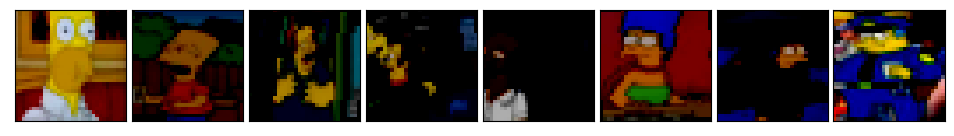

In [9]:
images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(12, 4))
for idx in np.arange(8):
    ax = fig.add_subplot(1, 8, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    plt.subplots_adjust(wspace=0.05, hspace=0.05)

## Модель

In [10]:
class CNN(nn.Module):
    def __init__(
        self,
        num_classes: int = 42,
    ):
        super().__init__()

        self.num_classes = num_classes
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())

        self.pool1 = nn.MaxPool2d(2,2)
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.pool2 = nn.MaxPool2d(2,2)
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512,
                      kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(512, num_classes)
        
        self.train_losses = []
        self.valid_losses = []
        self.test_metrics = []
        
    def forward(self, x: torch.Tensor):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.conv5(x)
        x = self.avg_pool(x)
        x = x.view(-1, 512)
        x = self.fc1(x)
        return x
    
    # Сохранить парметры модели
    def save(self, filename='./weights.pt'):
        torch.save(obj=self.state_dict(), f=filename)

    # Загрузить параметры модели
    def load(self, filename='./weights.pt'):
        loaded_state_dict = torch.load(filename)
        self.load_state_dict(loaded_state_dict)
    
    def train_step(self, epoch, optimizer, train_loader, criterion):
        # Здесь будет сумма loss'ов по всем батчам
        running_loss = 0.
        f1 = MulticlassF1Score(
        num_classes=num_classes, average="micro").to(device)
        
        for step, data in enumerate(train_loader, 0):
            # Переместить изображения и метки на устройство
            images, labels = data[0].to(device), data[1].to(device)

            # Удалить накопленные ранее градиенты
            optimizer.zero_grad()
            
            # Делаем проход (forward pass).
            # Состояние модели `train` обеспечивает сохранение промежуточных результатов вычислений.
            # Эти сохраненные значения будут использованы ниже для вычисления градиента функции потерь.
            outputs = self(images)
            
            # Получить индексы максимальных значений для каждой строки тензора outputs в измерении 1 (т.е. для каждого изображения в батче), обойти проверку Autograd
            _, predicted = torch.max(outputs.data, 1)

            # Обновить метрику f1.
            f1.update(predicted, labels)
            
            # Вычислить функцию потерь на основе предсказания модели.
            loss = criterion(outputs, labels)
            
            # Выполнить обратный проход и обновить параметры с помощью оптимизатора.
            loss.backward()
            
            # Обновить веса: parameter += -lr * parameter.grad
            # 
            # PyTorch SGD:
            # velocity = momentum * velocity + parameter.grad
            # parameter += - lr * velocity
            optimizer.step()

            # Накопление статистики - прибавить средний loss по батчу
            running_loss += loss.item()
        
        # Вернуть loss и метрику
        return running_loss, f1.compute()

    
    def valid_step(self, valid_loader, criterion):
        # Здесь будет сумма loss'ов по всем батчам
        running_loss = 0.
        f1 = MulticlassF1Score(
        num_classes=num_classes, average="micro").to(device)
        
        # Не считать градиент
        with torch.no_grad():
            for data in valid_loader:
                # Переместить изображения и метки на устройство
                inputs, labels = data[0].to(device), data[1].to(device)
                
                # Прямой проход
                outputs = self(inputs)
                
                # Получить индексы максимальных значений для каждой строки тензора outputs в измерении 1 (т.е. для каждого изображения в батче), обойти проверку Autograd
                _, predicted = torch.max(outputs.data, 1)  
                
                # Обновить метрику f1.
                f1.update(predicted, labels)
                
                # Вычислить функцию потерь на основе предсказания модели.
                loss = criterion(outputs, labels)
                
                # Накопление статистики - прибавить средний loss по батчу
                running_loss += loss.item()
       
        return running_loss, f1.compute()
        
        
        
    def train(self, train_loader, valid_loader, num_epochs=2, learning_rate=0.001, momentum=0.9, device=torch.device('cpu')):
        self.to(device)
        
        criterion = nn.CrossEntropyLoss()
        # optimizer = optim.SGD(self.parameters(), lr=learning_rate, momentum=momentum)
        optimizer = torch.optim.AdamW(self.parameters(), betas=(0.9, 0.999), lr=learning_rate, weight_decay = 0.00001)
        
        # Уменьшения скорости обучения на плато. Learning rate умножается на factor, как только в течение patience эпох метрика не улучшается.
        # verbose - вывод сообщений, threshold - порог улучшения метрики.
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, verbose=True, threshold=1e-4)
        
        writer = SummaryWriter(f"runs/")
        
        # Количество батчей, нужно чтобы получить средний loss по всем батчам из суммы
        train_batches_count = len(train_loader)
        val_batches_count = len(valid_loader)

        print('Training started')
        
        pbar = tqdm(range(num_epochs))
        for epoch in pbar:
            train_loss, train_f1 = self.train_step(epoch,optimizer, train_loader, criterion)
            valid_loss, valid_f1 = self.valid_step(valid_loader,criterion)     
            
            scheduler.step(valid_loss/val_batches_count)
            
            writer.add_scalars(f"Losses",{"Train": train_loss/train_batches_count,"Valid": valid_loss/val_batches_count}, epoch)
            writer.add_scalars(f"Metrics",{"Train": train_f1,"Valid": valid_f1 }, epoch)
            
            self.train_losses.append(train_loss/train_batches_count)
            self.valid_losses.append(valid_loss/val_batches_count)
            
        print('Training finished')
        

    def test(self, test_loader):

        f1 = MulticlassF1Score(
        num_classes=num_classes, average="micro").to(device)
        class_f1 = MulticlassF1Score(
        num_classes=num_classes, average=None).to(device)
        
        print('Testing started')
        
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                
                outputs = self(images)

                _, predicted = torch.max(outputs.data, 1)
                   
                f1.update(predicted,labels)
                class_f1.update(predicted,labels)
                
        self.test_metrics = class_f1.compute() 
        
        print('Testing finished')     
        print(f"F1(average): {f1.compute():.3%}")

In [11]:
num_classes = len(dataset.classes)
model = CNN(num_classes)
[(name, parameter.shape) for name, parameter in model.named_parameters()]

[('conv1.0.weight', torch.Size([32, 3, 3, 3])),
 ('conv1.0.bias', torch.Size([32])),
 ('conv1.1.weight', torch.Size([32])),
 ('conv1.1.bias', torch.Size([32])),
 ('conv1.3.weight', torch.Size([64, 32, 3, 3])),
 ('conv1.3.bias', torch.Size([64])),
 ('conv1.4.weight', torch.Size([64])),
 ('conv1.4.bias', torch.Size([64])),
 ('conv2.0.weight', torch.Size([64, 64, 3, 3])),
 ('conv2.0.bias', torch.Size([64])),
 ('conv2.1.weight', torch.Size([64])),
 ('conv2.1.bias', torch.Size([64])),
 ('conv2.3.weight', torch.Size([128, 64, 3, 3])),
 ('conv2.3.bias', torch.Size([128])),
 ('conv2.4.weight', torch.Size([128])),
 ('conv2.4.bias', torch.Size([128])),
 ('conv3.0.weight', torch.Size([128, 128, 3, 3])),
 ('conv3.0.bias', torch.Size([128])),
 ('conv3.1.weight', torch.Size([128])),
 ('conv3.1.bias', torch.Size([128])),
 ('conv3.3.weight', torch.Size([256, 128, 3, 3])),
 ('conv3.3.bias', torch.Size([256])),
 ('conv3.4.weight', torch.Size([256])),
 ('conv3.4.bias', torch.Size([256])),
 ('conv4.0.weig

## Training

In [12]:
model.train(train_loader, valid_loader, device=device, num_epochs = 30)


Training started


 97%|█████████▋| 29/30 [04:50<00:09,  9.47s/it]

Epoch 00029: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 30/30 [05:03<00:00, 10.10s/it]

Training finished


In [13]:
# Сохранить веса
from datetime import datetime
date = datetime.now().strftime('weights_%H_%M_%d_%m_%Y.pt')
model.save(date)

Text(0, 0.5, 'Loss')

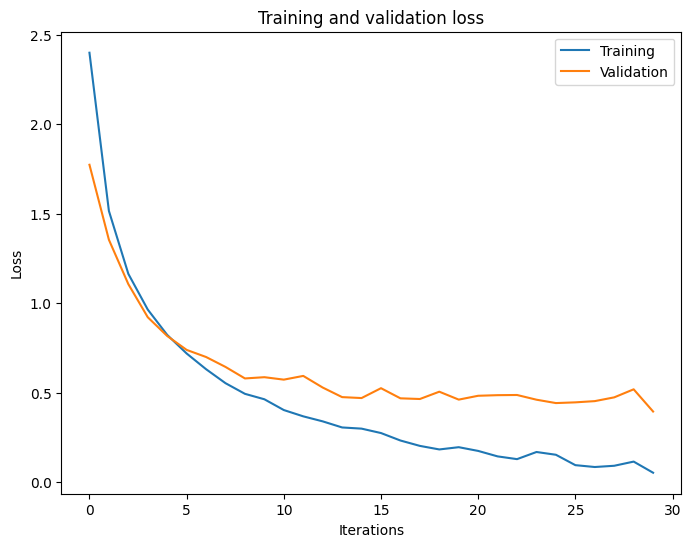

In [14]:
fig = plt.figure(figsize=(8, 6))
plt.plot(model.train_losses,label = 'Training')
plt.plot(model.valid_losses,label = 'Validation')
plt.legend()
plt.title('Training and validation loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')

## Testing

In [15]:
model.test(test_loader)

Testing started
Testing finished
F1(average): 90.970%


<BarContainer object of 42 artists>

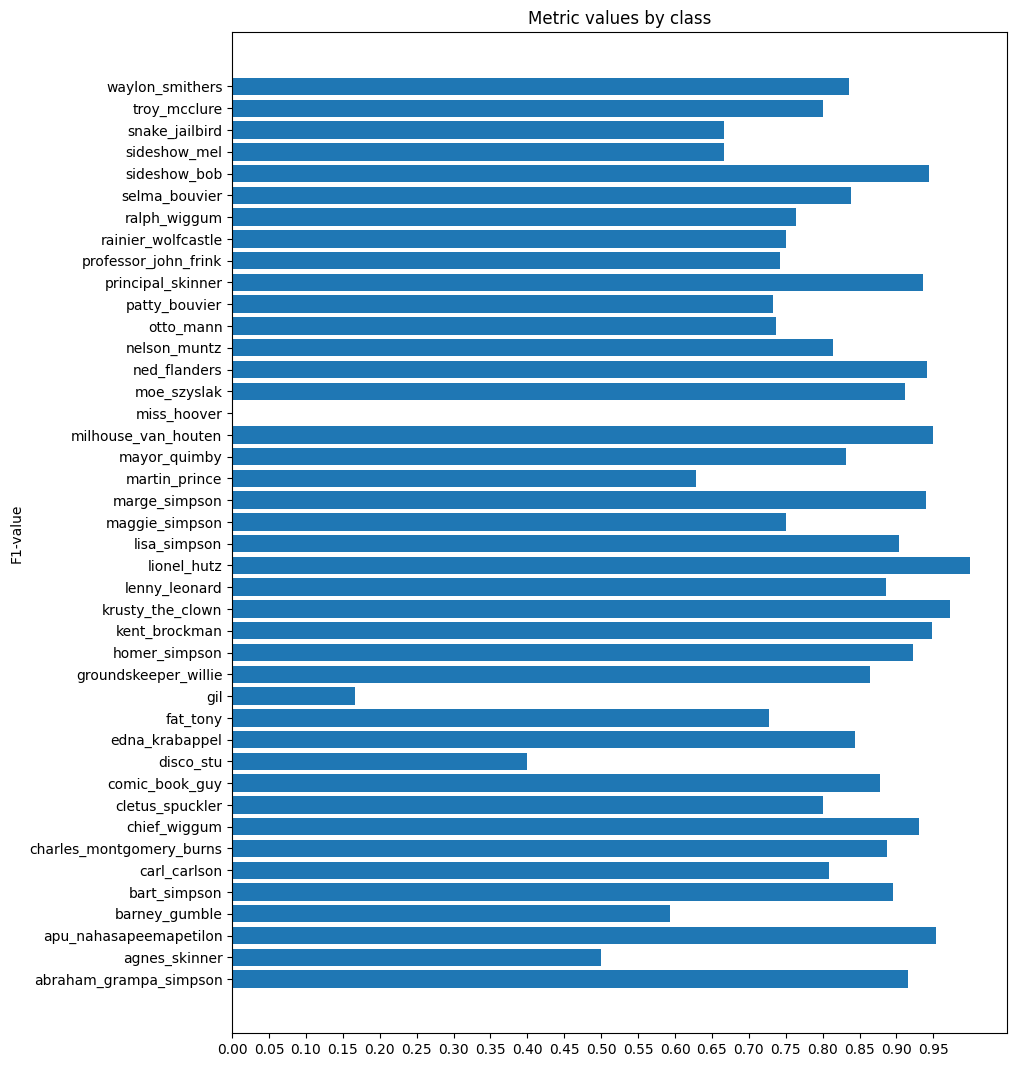

In [16]:
# Показать столбчатую диаграмму метрик для каждого класса
bar = plt.figure(figsize=(10, 13))
plt.title("Metric values by class")
plt.ylabel('F1-value')
plt.xticks(ticks=np.arange(0, 1.00, 0.05))
plt.barh(dataset.classes, np.array(model.test_metrics.cpu()))